In [263]:
import numpy as np
from typing import Optional
import seaborn as sns
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import sympy as sp
import pandas as pd

## M1 DA Light Node

In [264]:
m1_da_light_node_df = pd.read_json("../data/m1-da-light-node-timing.log", lines=True)
m1_da_light_node_df

,timestamp,level,fields,target
0,2024-07-28 17:54:58.374385+00:00,INFO,"{'message': 'waiting_for_next_block', 'uid': '...",movement_timing
1,2024-07-28 17:54:58.626819+00:00,INFO,"{'message': 'received_block', 'block_id': 'ea0...",movement_timing
2,2024-07-28 17:54:58.627092+00:00,INFO,"{'message': 'submitting_block', 'block_id': 'e...",movement_timing
3,2024-07-28 17:55:00.291007+00:00,INFO,"{'message': 'submitted_block', 'block_id': 'ea...",movement_timing
4,2024-07-28 17:55:00.291069+00:00,INFO,"{'message': 'waiting_for_next_block', 'uid': '...",movement_timing
...,...,...,...,...
40302,2024-07-28 21:05:11.343386+00:00,INFO,"{'message': 'waiting_for_next_block', 'uid': '...",movement_timing
40303,2024-07-28 21:05:11.597104+00:00,INFO,"{'message': 'waiting_for_next_block', 'uid': '...",movement_timing
40304,2024-07-28 21:05:11.851760+00:00,INFO,"{'message': 'waiting_for_next_block', 'uid': '...",movement_timing
40305,2024-07-28 21:05:12.115923+00:00,INFO,"{'message': 'waiting_for_next_block', 'uid': '...",movement_timing


### General

#### Expand the JSON Fields and Clean General Data

In [265]:
# expand the fields in 'fields' into their own columns
m1_da_light_node_df = pd.concat([m1_da_light_node_df.drop(['fields'], axis=1), m1_da_light_node_df['fields'].apply(pd.Series)], axis=1)

# convert the 'timestamp' field to a datetime object
# timestamp will be in this format: 2024-07-28 17:54:58.374385+00:00
m1_da_light_node_df['timestamp'] = pd.to_datetime(m1_da_light_node_df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f%z')

m1_da_light_node_df

,timestamp,level,target,message,uid,block_id,transaction_count
0,2024-07-28 17:54:58.374385+00:00,INFO,movement_timing,waiting_for_next_block,974e57c9-1191-481f-9fe5-79fb5c7d245a,NaN,NaN
1,2024-07-28 17:54:58.626819+00:00,INFO,movement_timing,received_block,974e57c9-1191-481f-9fe5-79fb5c7d245a,ea0d474202d6ad4317f3ab561b8e34b7d236ea24cbb400...,NaN
2,2024-07-28 17:54:58.627092+00:00,INFO,movement_timing,submitting_block,NaN,ea0d474202d6ad4317f3ab561b8e34b7d236ea24cbb400...,1.0
3,2024-07-28 17:55:00.291007+00:00,INFO,movement_timing,submitted_block,NaN,ea0d474202d6ad4317f3ab561b8e34b7d236ea24cbb400...,NaN
4,2024-07-28 17:55:00.291069+00:00,INFO,movement_timing,waiting_for_next_block,963c3426-4f87-47c5-89a6-753765f9312b,NaN,NaN
...,...,...,...,...,...,...,...
40302,2024-07-28 21:05:11.343386+00:00,INFO,movement_timing,waiting_for_next_block,d921782d-bfd3-4a3b-91ce-1a2fea6487fa,NaN,NaN
40303,2024-07-28 21:05:11.597104+00:00,INFO,movement_timing,waiting_for_next_block,eef65d8d-c137-47fe-a92f-d52ee12de601,NaN,NaN
40304,2024-07-28 21:05:11.851760+00:00,INFO,movement_timing,waiting_for_next_block,0db3c23e-f64e-4195-b60f-7f31e916f288,NaN,NaN
40305,2024-07-28 21:05:12.115923+00:00,INFO,movement_timing,waiting_for_next_block,260ff2f0-9af2-4b6e-92a6-070037d25a2b,NaN,NaN


### Block Submission

#### Form Block Submission Dataframe

In [266]:
# Block Submission Dataframe contains only records where 'message' is 'submitting_block' or 'submitted_block'
block_submission_df = m1_da_light_node_df[(m1_da_light_node_df['message'] == 'submitting_block') | (m1_da_light_node_df['message'] == 'submitted_block')]

# drop uid and transaction_count
block_submission_df = block_submission_df.drop(['uid', 'transaction_count'], axis=1)

# group by 'block_id' and subtract the time of 'submitting_block' from 'submitted_block' to get the latency
block_submission_df = block_submission_df.groupby('block_id').agg({'timestamp': ['min', 'max']})
block_submission_df['latency'] = block_submission_df['timestamp']['max'] - block_submission_df['timestamp']['min']
block_submission_df['latency_ms'] = block_submission_df['latency'].dt.total_seconds() * 1000

block_submission_df

timestamp  \
                                                                                min   
block_id                                                                              
006df4044b46201aa217017ae1d46dec7acdfb30573c413... 2024-07-28 17:59:39.067457+00:00   
00a10c8d534bf76c7e6a4c344963b4eb03b33dd2824803c... 2024-07-28 17:56:23.266156+00:00   
015ebe290759317770e7bdb9392c0bd6e18a3b460119b33... 2024-07-28 18:10:31.294481+00:00   
01854f080d9b1b2fdfe7b03ec41938ba612115fdef8102d... 2024-07-28 18:14:05.162622+00:00   
01e2a6e912f51fad477c1b66f6487fa590cd9631949c312... 2024-07-28 18:12:18.427533+00:00   
...                                                                             ...   
fd8b87ac3f9c6a0201b7ed03f8caad7415d066cc49f5147... 2024-07-28 18:36:02.498266+00:00   
fd8fed16ab99927ca1f4a887c15f01df6d6845faddf2124... 2024-07-28 18:42:23.608001+00:00   
ff100c9ed4a66939a339ec57a4a2a342853419dcbc2b581... 2024-07-28 18:05:08.241916+00:00   
ff1fdf6e8f3f8b231aeaea49896b1a11c72686d55c47092... 2024-07-28 18:42:52.398690+00:00   
fff2248eeb345a59e621c35e64a675fd25fb0b48da1187e... 2024-07-28 19:15:33.928244+00:00   

                                                                                     \
                                                                                max   
block_id                                                                              
006df4044b46201aa217017ae1d46dec7acdfb30573c413... 2024-07-28 17:59:40.840422+00:00   
00a10c8d534bf76c7e6a4c344963b4eb03b33dd2824803c... 2024-07-28 17:56:25.048753+00:00   
015ebe290759317770e7bdb9392c0bd6e18a3b460119b33... 2024-07-28 18:10:32.345470+00:00   
01854f080d9b1b2fdfe7b03ec41938ba612115fdef8102d... 2024-07-28 18:14:06.221246+00:00   
01e2a6e912f51fad477c1b66f6487fa590cd9631949c312... 2024-07-28 18:12:20.201528+00:00   
...                                                                             ...   
fd8b87ac3f9c6a0201b7ed03f8caad7415d066cc49f5147... 2024-07-28 18:36:04.276212+00:00   
fd8fed16ab99927ca1f4a887c15f01df6d6845faddf2124... 2024-07-28 18:42:25.408977+00:00   
ff100c9ed4a66939a339ec57a4a2a342853419dcbc2b581... 2024-07-28 18:05:10.146421+00:00   
ff1fdf6e8f3f8b231aeaea49896b1a11c72686d55c47092... 2024-07-28 18:42:54.247221+00:00   
fff2248eeb345a59e621c35e64a675fd25fb0b48da1187e... 2024-07-28 19:15:35.704421+00:00   

                                                                  latency  \
                                                                            
block_id                                                                    
006df4044b46201aa217017ae1d46dec7acdfb30573c413... 0 days 00:00:01.772965   
00a10c8d534bf76c7e6a4c344963b4eb03b33dd2824803c... 0 days 00:00:01.782597   
015ebe290759317770e7bdb9392c0bd6e18a3b460119b33... 0 days 00:00:01.050989   
01854f080d9b1b2fdfe7b03ec41938ba612115fdef8102d... 0 days 00:00:01.058624   
01e2a6e912f51fad477c1b66f6487fa590cd9631949c312... 0 days 00:00:01.773995   
...                                                                   ...   
fd8b87ac3f9c6a0201b7ed03f8caad7415d066cc49f5147... 0 days 00:00:01.777946   
fd8fed16ab99927ca1f4a887c15f01df6d6845faddf2124... 0 days 00:00:01.800976   
ff100c9ed4a66939a339ec57a4a2a342853419dcbc2b581... 0 days 00:00:01.904505   
ff1fdf6e8f3f8b231aeaea49896b1a11c72686d55c47092... 0 days 00:00:01.848531   
fff2248eeb345a59e621c35e64a675fd25fb0b48da1187e... 0 days 00:00:01.776177   

                                                   latency_ms  
                                                               
block_id                                                       
006df4044b46201aa217017ae1d46dec7acdfb30573c413...   1772.965  
00a10c8d534bf76c7e6a4c344963b4eb03b33dd2824803c...   1782.597  
015ebe290759317770e7bdb9392c0bd6e18a3b460119b33...   1050.989  
01854f080d9b1b2fdfe7b03ec41938ba612115fdef8102d...   1058.624  
01e2a6e912f51fad477c1b66f6487fa590cd9631949c312...   1773.995  
...                                          

#### Describe the Submission Dataframe

In [267]:
block_submission_df['latency_ms'].describe()

count      769.000000
mean      2131.384213
std       1843.600018
min        114.261000
25%       1766.749000
50%       1791.343000
75%       1834.009000
max      15076.781000
Name: latency_ms, dtype: float64

/Users/l-monninger/dev/movement/research/movement-transaction-dataflow-v0_0_1/venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='latency_ms', ylabel='Count'>

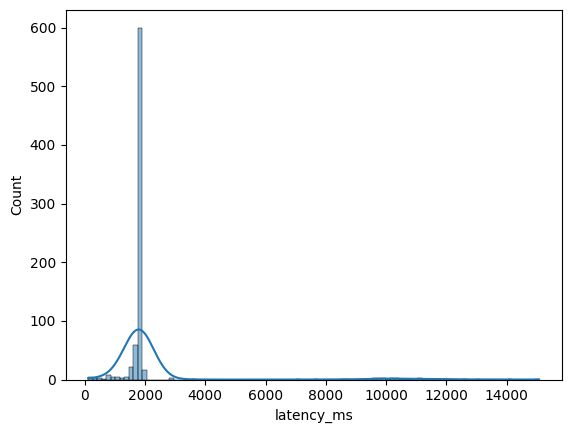

In [268]:
# histogram of block submission latency
sns.histplot(block_submission_df['latency_ms'], bins=100, kde=True)

#### Blocks Submitted Over Time

In [269]:
# plot the block submissions by average latency per minute
block_submission_ot_df = pd.DataFrame()
block_submission_ot_df['start_timestamp'] = block_submission_df['timestamp']['min']
block_submission_ot_df['latency_ms'] = block_submission_df['latency_ms']
block_submission_ot_df['minute'] = block_submission_ot_df['start_timestamp'].dt.floor('T')

# group by minute and calculate the average latency
block_submission_ot_df = block_submission_ot_df.groupby('minute').agg({'latency_ms': ['mean', 'count']})

block_submission_ot_df

/tmp/nix-shell.Y1yRQU/ipykernel_82869/1422079454.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  block_submission_ot_df['minute'] = block_submission_ot_df['start_timestamp'].dt.floor('T')


latency_ms      
                                  mean count
minute                                      
2024-07-28 17:54:00+00:00  1663.915000     1
2024-07-28 17:55:00+00:00   230.284000     1
2024-07-28 17:56:00+00:00  2198.052375    16
2024-07-28 17:57:00+00:00  1771.689000     3
2024-07-28 17:58:00+00:00  1803.808357    14
...                                ...   ...
2024-07-28 20:15:00+00:00  2346.120176    17
2024-07-28 20:31:00+00:00  1444.625000     2
2024-07-28 20:32:00+00:00  2306.061739    23
2024-07-28 20:33:00+00:00  1835.596000     9
2024-07-28 20:38:00+00:00  1704.832571     7

[67 rows x 2 columns]

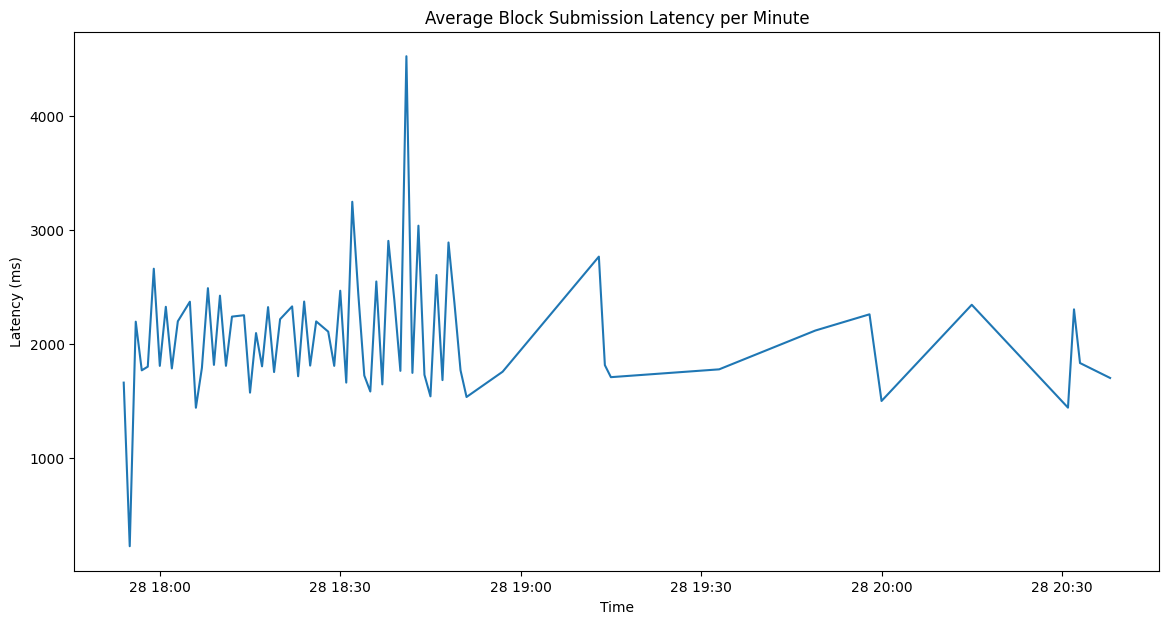

In [270]:
# plot the average block submission latency per minute
plt.figure(figsize=(14, 7))
plt.plot(block_submission_ot_df.index, block_submission_ot_df['latency_ms']['mean'])
plt.xlabel('Time')
plt.ylabel('Latency (ms)')
plt.title('Average Block Submission Latency per Minute')
plt.show()

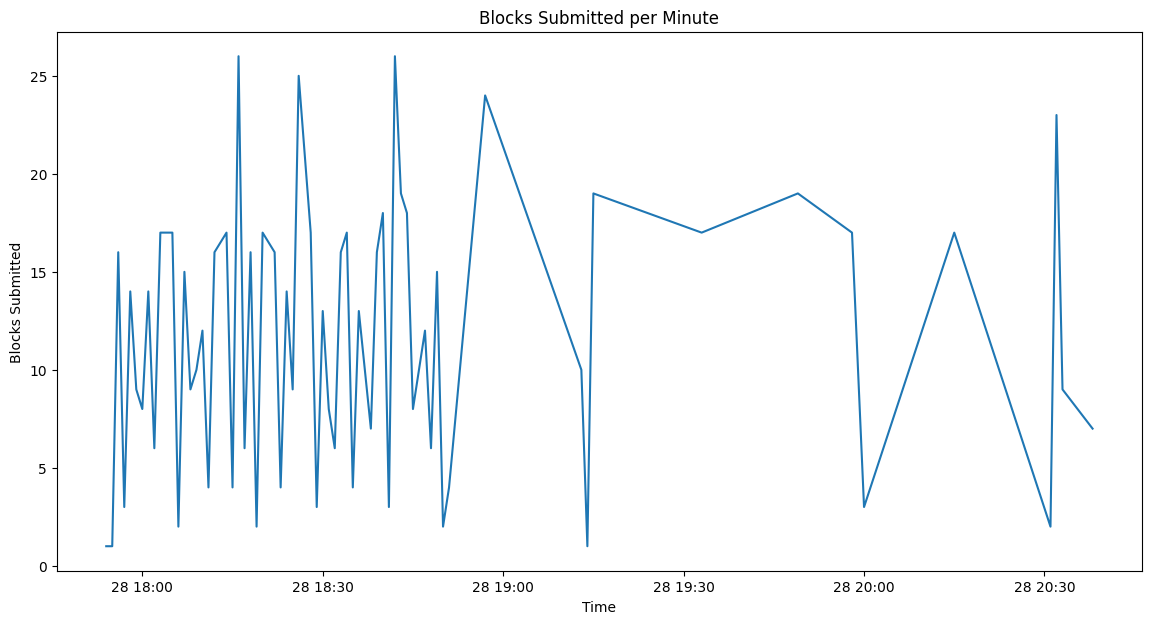

In [271]:
# plot the number of blocks submitted per minute by finish time
plt.figure(figsize=(14, 7))
plt.plot(block_submission_ot_df.index, block_submission_ot_df['latency_ms']['count'])
plt.xlabel('Time')
plt.ylabel('Blocks Submitted')
plt.title('Blocks Submitted per Minute')
plt.show()

### Block Building

#### Form Block Building Dataframe

In [272]:
# Block Building Dataframe contains only records where 'message' is 'waiting_for_next_block' or 'received_block'
block_building_df = m1_da_light_node_df[(m1_da_light_node_df['message'] == 'waiting_for_next_block') | (m1_da_light_node_df['message'] == 'received_block')]

# drop transaction count 
block_building_df = block_building_df.drop(['transaction_count'], axis=1)

# group bu 'uid' and subtract the time of 'waiting_for_next_block' from 'received_block' to get the latency, preserve the block_id field
block_building_df = block_building_df.groupby('uid').agg({'timestamp': ['min', 'max'], 'block_id': 'last'})
# drop records where there is no 'block_id', i.e., no 'received_block' message
block_building_df = block_building_df.dropna(subset=[('block_id', 'last')])
block_building_df['latency'] = block_building_df['timestamp']['max'] - block_building_df['timestamp']['min']

# convert the latency to milliseconds
block_building_df['latency_ms'] = block_building_df['latency'].dt.total_seconds() * 1000

block_building_df

timestamp  \
                                                                  min   
uid                                                                     
0030c5b7-c476-4790-be47-ab67da1daf9e 2024-07-28 20:32:53.162911+00:00   
003127b5-2430-48be-b1e6-7abd9a79ad12 2024-07-28 18:37:43.273180+00:00   
003df605-8271-43ab-bb06-b0a1827dd727 2024-07-28 18:31:57.826276+00:00   
00963f18-8cbe-4372-8b75-46a13ce24944 2024-07-28 18:42:35.659185+00:00   
00ac3f89-0640-4401-8d78-e8c4fe1a7565 2024-07-28 20:32:59.072237+00:00   
...                                                               ...   
fd20793d-208d-4197-aede-ccf3cbc3d08c 2024-07-28 19:13:48.950329+00:00   
fe5d0724-92e5-48a9-89f2-895120a95ee1 2024-07-28 18:45:55.333945+00:00   
ff40c14c-1839-4087-82c8-146a2bbd957c 2024-07-28 18:43:46.782110+00:00   
ff60117f-1ed0-4544-b3dc-e2aecd915062 2024-07-28 18:16:19.075203+00:00   
ffc7ed52-9ffb-40a7-97f9-df2704f97f7e 2024-07-28 18:42:09.002032+00:00   

                                                                       \
                                                                  max   
uid                                                                     
0030c5b7-c476-4790-be47-ab67da1daf9e 2024-07-28 20:32:53.428043+00:00   
003127b5-2430-48be-b1e6-7abd9a79ad12 2024-07-28 18:37:43.534570+00:00   
003df605-8271-43ab-bb06-b0a1827dd727 2024-07-28 18:31:58.086670+00:00   
00963f18-8cbe-4372-8b75-46a13ce24944 2024-07-28 18:42:35.917802+00:00   
00ac3f89-0640-4401-8d78-e8c4fe1a7565 2024-07-28 20:32:59.347815+00:00   
...                                                               ...   
fd20793d-208d-4197-aede-ccf3cbc3d08c 2024-07-28 19:13:49.202733+00:00   
fe5d0724-92e5-48a9-89f2-895120a95ee1 2024-07-28 18:45:55.591687+00:00   
ff40c14c-1839-4087-82c8-146a2bbd957c 2024-07-28 18:43:47.044104+00:00   
ff60117f-1ed0-4544-b3dc-e2aecd915062 2024-07-28 18:16:19.329902+00:00   
ffc7ed52-9ffb-40a7-97f9-df2704f97f7e 2024-07-28 18:42:09.259239+00:00   

                                                                               block_id  \
                                                                                   last   
uid                                                                                       
0030c5b7-c476-4790-be47-ab67da1daf9e  0d5b7307ed5ed80a94719beda69993f02e4be19880c1e7...   
003127b5-2430-48be-b1e6-7abd9a79ad12  ee1cd18ff0a882aa924ddebb637f692e48cd6a47ebea52...   
003df605-8271-43ab-bb06-b0a1827dd727  e1ab6e42326297e2a27761e397b5297b76258ba424880f...   
00963f18-8cbe-4372-8b75-46a13ce24944  c039a80ce968db9a2513a8b56826fab877771de0a6df75...   
00ac3f89-0640-4401-8d78-e8c4fe1a7565  5edc7cedbdaad3191526f111eb2706d1b10f43265cfc6a...   
...                                                                                 ...   
fd20793d-208d-4197-aede-ccf3cbc3d08c  47c0b6affe7424787e7248d19c21c5c6b3401009a92444...   
fe5d0724-92e5-48a9-89f2-895120a95ee1  da6fbc5d66df7176b127a82e2460bcaf2c1825d6be489e...   
ff40c14c-1839-4087-82c8-146a2bbd957c  a39a9370fa7a35d1a98c6f40e1dd9a7b4b190c8b291cc2...   
ff60117f-1ed0-4544-b3dc-e2aecd915062  3c1a9be6f51df12c26a6997d6a9782fd4ca737ef427eb5...   
ffc7ed52-9ffb-40a7-97f9-df2704f97f7e  7985df44356a53391f4c6dac80a78f5e0390ddb4622809...   

                                                    latency latency_ms  
                                                                        
uid                                                                     
0030c5b7-c476-4790-be47-ab67da1daf9e 0 days 00:00:00.265132    265.132  
003127b5-2430-48be-b1e6-7abd9a79ad12 0 days 00:00:00.261390    261.390  
003df605-8271-43ab-bb06-b0a1827dd727 0 days 00:00:00.260394    260.394  
00963f18-8cbe-4372-8b75-46a13ce24944 0 days 00:00:00.258617    258.617  
00ac3f89-0640-4401-8d78-e8c4fe1a7565 0 days 00:00:00.275578    275.578  
...                                                     ...        ...  
fd20793d-208d-4197-aede-ccf3cbc3d08c 0 days 00:00:00.252404    252.404  
fe5d0724-

In [273]:
block_building_df['latency_ms'].describe()

count    769.000000
mean     252.146456
std       33.658196
min       11.839000
25%      253.608000
50%      256.674000
75%      259.846000
max      275.578000
Name: latency_ms, dtype: float64

/Users/l-monninger/dev/movement/research/movement-transaction-dataflow-v0_0_1/venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='latency_ms', ylabel='Count'>

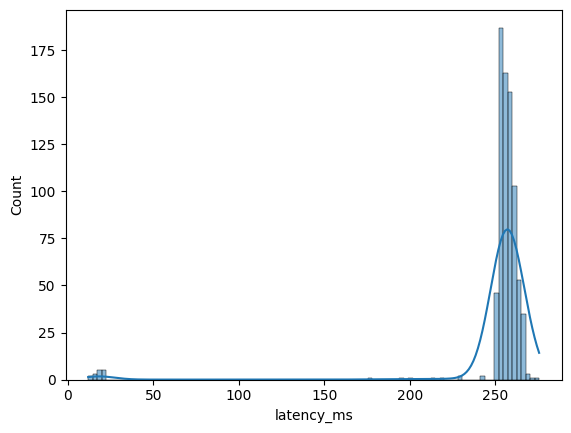

In [274]:
# histogram of block building latency
sns.histplot(block_building_df['latency_ms'], bins=100, kde=True)

### Blocks Built Over Time

In [275]:
# plot the block building by average latency per minute
block_building_ot_df = pd.DataFrame()
block_building_ot_df['start_timestamp'] = block_building_df['timestamp']['min']
block_building_ot_df['latency_ms'] = block_building_df['latency_ms']
block_building_ot_df['minute'] = block_building_ot_df['start_timestamp'].dt.floor('T')

# group by minute and calculate the average latency
block_building_ot_df = block_building_ot_df.groupby('minute').agg({'latency_ms': ['mean', 'count']})

block_building_ot_df

/tmp/nix-shell.Y1yRQU/ipykernel_82869/1995467482.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  block_building_ot_df['minute'] = block_building_ot_df['start_timestamp'].dt.floor('T')


latency_ms      
                                 mean count
minute                                     
2024-07-28 17:54:00+00:00  252.434000     1
2024-07-28 17:55:00+00:00  253.163000     1
2024-07-28 17:56:00+00:00  255.787813    16
2024-07-28 17:57:00+00:00  255.219667     3
2024-07-28 17:58:00+00:00  254.211857    14
...                               ...   ...
2024-07-28 20:15:00+00:00  260.609765    17
2024-07-28 20:31:00+00:00  261.098000     2
2024-07-28 20:32:00+00:00  262.011957    23
2024-07-28 20:33:00+00:00  259.896222     9
2024-07-28 20:38:00+00:00  261.308429     7

[67 rows x 2 columns]

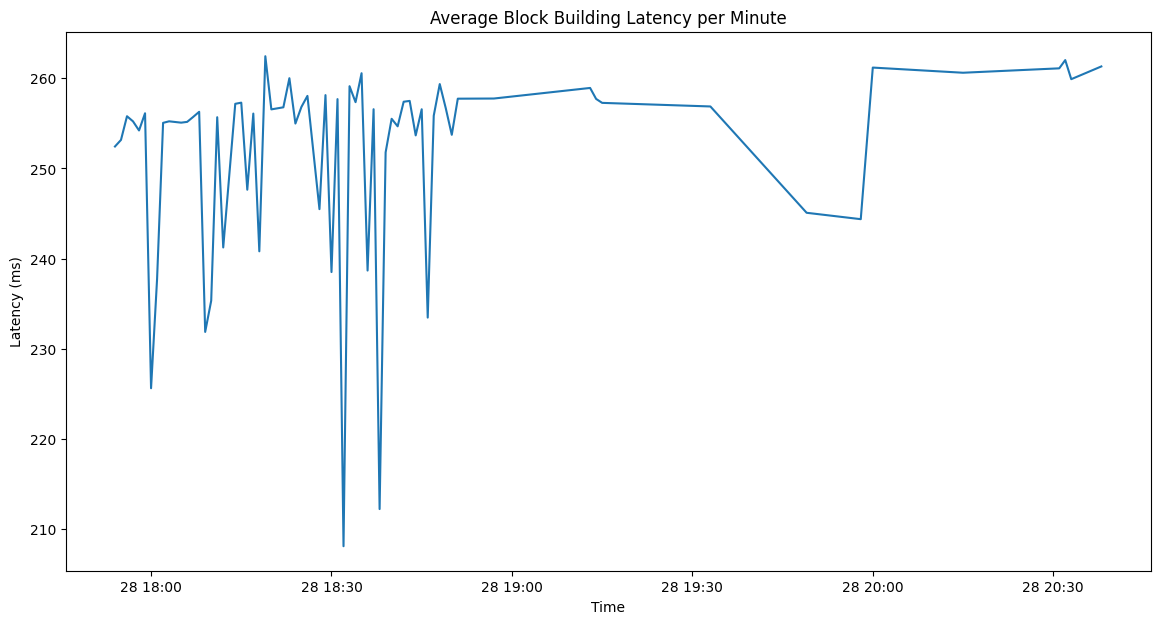

In [276]:
# plot the block building average latency per minute
plt.figure(figsize=(14, 7))
plt.plot(block_building_ot_df.index, block_building_ot_df['latency_ms']['mean'])
plt.xlabel('Time')
plt.ylabel('Latency (ms)')
plt.title('Average Block Building Latency per Minute')
plt.show()

## Suzuka

In [277]:
suzuka_df = pd.read_json("../data/movement-timing.log", lines=True)
suzuka_df

,timestamp,level,fields,target,span,spans
0,2024-07-28 17:55:01.778955+00:00,INFO,"{'message': 'close', 'time.busy': '87.3µs', 't...",movement_timing,{'sender': '0xa6802425367ed2dbc21838723bf0a614...,[]
1,2024-07-28 17:55:01.779052+00:00,INFO,"{'message': 'received transaction', 'batch_id'...",movement_timing,NaN,NaN
2,2024-07-28 17:55:01.881766+00:00,INFO,"{'message': 'close', 'time.busy': '63.1µs', 't...",movement_timing,{'batch_id': '1ab59aec-75d1-4d48-8441-63e0fbe8...,[]
3,2024-07-28 17:55:01.900659+00:00,INFO,"{'message': 'close', 'time.busy': '21.7µs', 't...",movement_timing,{'sender': '0x131719462867bad07bb8ed09ebb55935...,[]
4,2024-07-28 17:55:01.900699+00:00,INFO,"{'message': 'received transaction', 'batch_id'...",movement_timing,NaN,NaN
...,...,...,...,...,...,...
269628,2024-07-28 20:38:17.047641+00:00,INFO,"{'message': 'transaction_in_block', 'tx_hash':...",movement_timing,"{'id': '""4/Xj2wvtHzjV5jId0U3uzF5veRE6+e9CFq89o...","[{'id': '""4/Xj2wvtHzjV5jId0U3uzF5veRE6+e9CFq89..."
269629,2024-07-28 20:38:17.047666+00:00,INFO,"{'message': 'transaction_in_block', 'tx_hash':...",movement_timing,"{'id': '""4/Xj2wvtHzjV5jId0U3uzF5veRE6+e9CFq89o...","[{'id': '""4/Xj2wvtHzjV5jId0U3uzF5veRE6+e9CFq89..."
269630,2024-07-28 20:38:17.047692+00:00,INFO,"{'message': 'transaction_in_block', 'tx_hash':...",movement_timing,"{'id': '""4/Xj2wvtHzjV5jId0U3uzF5veRE6+e9CFq89o...","[{'id': '""4/Xj2wvtHzjV5jId0U3uzF5veRE6+e9CFq89..."
269631,2024-07-28 20:38:17.047718+00:00,INFO,"{'message': 'transaction_in_block', 'tx_hash':...",movement_timing,"{'id': '""4/Xj2wvtHzjV5jId0U3uzF5veRE6+e9CFq89o...","[{'id': '""4/Xj2wvtHzjV5jId0U3uzF5veRE6+e9CFq89..."


In [278]:
# convert the 'timestamp' field to a datetime object
# timestamp will be in this format: 2024-07-28 17:54:58.374385+00:00
suzuka_df['timestamp'] = pd.to_datetime(suzuka_df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f%z')

suzuka_df

,timestamp,level,fields,target,span,spans
0,2024-07-28 17:55:01.778955+00:00,INFO,"{'message': 'close', 'time.busy': '87.3µs', 't...",movement_timing,{'sender': '0xa6802425367ed2dbc21838723bf0a614...,[]
1,2024-07-28 17:55:01.779052+00:00,INFO,"{'message': 'received transaction', 'batch_id'...",movement_timing,NaN,NaN
2,2024-07-28 17:55:01.881766+00:00,INFO,"{'message': 'close', 'time.busy': '63.1µs', 't...",movement_timing,{'batch_id': '1ab59aec-75d1-4d48-8441-63e0fbe8...,[]
3,2024-07-28 17:55:01.900659+00:00,INFO,"{'message': 'close', 'time.busy': '21.7µs', 't...",movement_timing,{'sender': '0x131719462867bad07bb8ed09ebb55935...,[]
4,2024-07-28 17:55:01.900699+00:00,INFO,"{'message': 'received transaction', 'batch_id'...",movement_timing,NaN,NaN
...,...,...,...,...,...,...
269628,2024-07-28 20:38:17.047641+00:00,INFO,"{'message': 'transaction_in_block', 'tx_hash':...",movement_timing,"{'id': '""4/Xj2wvtHzjV5jId0U3uzF5veRE6+e9CFq89o...","[{'id': '""4/Xj2wvtHzjV5jId0U3uzF5veRE6+e9CFq89..."
269629,2024-07-28 20:38:17.047666+00:00,INFO,"{'message': 'transaction_in_block', 'tx_hash':...",movement_timing,"{'id': '""4/Xj2wvtHzjV5jId0U3uzF5veRE6+e9CFq89o...","[{'id': '""4/Xj2wvtHzjV5jId0U3uzF5veRE6+e9CFq89..."
269630,2024-07-28 20:38:17.047692+00:00,INFO,"{'message': 'transaction_in_block', 'tx_hash':...",movement_timing,"{'id': '""4/Xj2wvtHzjV5jId0U3uzF5veRE6+e9CFq89o...","[{'id': '""4/Xj2wvtHzjV5jId0U3uzF5veRE6+e9CFq89..."
269631,2024-07-28 20:38:17.047718+00:00,INFO,"{'message': 'transaction_in_block', 'tx_hash':...",movement_timing,"{'id': '""4/Xj2wvtHzjV5jId0U3uzF5veRE6+e9CFq89o...","[{'id': '""4/Xj2wvtHzjV5jId0U3uzF5veRE6+e9CFq89..."


In [279]:
# suzuka_fields_df is expanded fields where 'fields' is not null
suzuka_fields_df = suzuka_df.dropna(subset=['fields'])

# expand 'fields'
suzuka_fields_df = pd.concat([suzuka_fields_df.drop(['fields'], axis=1), suzuka_fields_df['fields'].apply(pd.Series)], axis=1)

suzuka_fields_df['message'].value_counts()

message
close                   96978
received transaction    87298
transaction_in_block    85357
Name: count, dtype: int64

In [280]:
# suzuka_span_df is expanded 'span' where 'span' is not null
suzuka_span_df = suzuka_df.dropna(subset=['span'])

# expand the 'span' if it is not null
suzuka_span_df = pd.concat([suzuka_span_df.drop(['span'], axis=1), suzuka_span_df['span'].apply(pd.Series)], axis=1)

# wherever the message is 'close' we then want to use the 'name' as the 'message'
suzuka_span_df['message'] = suzuka_span_df['name']

suzuka_span_df['message'].value_counts()

message
submit_transaction    87298
execute_block         86105
batch_write            8932
Name: count, dtype: int64

In [281]:
suzuka_df = pd.concat([suzuka_fields_df, suzuka_span_df])
suzuka_df

,timestamp,level,target,span,spans,message,time.busy,time.idle,batch_id,tx_hash,sender,sequence_number,block_id,fields,name,length,id
0,2024-07-28 17:55:01.778955+00:00,INFO,movement_timing,{'sender': '0xa6802425367ed2dbc21838723bf0a614...,[],close,87.3µs,5.12µs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-07-28 17:55:01.779052+00:00,INFO,movement_timing,NaN,NaN,received transaction,NaN,NaN,1ab59aec-75d1-4d48-8441-63e0fbe8d0c6,c2fc7efd,0xa6802425367ed2dbc21838723bf0a61472248e24cafe...,40.0,NaN,NaN,NaN,NaN,NaN
2,2024-07-28 17:55:01.881766+00:00,INFO,movement_timing,{'batch_id': '1ab59aec-75d1-4d48-8441-63e0fbe8...,[],close,63.1µs,1.61ms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-07-28 17:55:01.900659+00:00,INFO,movement_timing,{'sender': '0x131719462867bad07bb8ed09ebb55935...,[],close,21.7µs,3.02µs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-07-28 17:55:01.900699+00:00,INFO,movement_timing,NaN,NaN,received transaction,NaN,NaN,9d68a6ca-eadf-40ad-9068-7abe23b2bdf2,e42542c1,0x131719462867bad07bb8ed09ebb559352ed265e38b54...,41.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269628,2024-07-28 20:38:17.047641+00:00,INFO,movement_timing,NaN,"[{'id': '""4/Xj2wvtHzjV5jId0U3uzF5veRE6+e9CFq89...",execute_block,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'message': 'transaction_in_block', 'tx_hash':...",execute_block,NaN,"""4/Xj2wvtHzjV5jId0U3uzF5veRE6+e9CFq89okPElrk="""
269629,2024-07-28 20:38:17.047666+00:00,INFO,movement_timing,NaN,"[{'id': '""4/Xj2wvtHzjV5jId0U3uzF5veRE6+e9CFq89...",execute_block,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'message': 'transaction_in_block', 'tx_hash':...",execute_block,NaN,"""4/Xj2wvtHzjV5jId0U3uzF5veRE6+e9CFq89okPElrk="""
269630,2024-07-28 20:38:17.047692+00:00,INFO,movement_timing,NaN,"[{'id': '""4/Xj2wvtHzjV5jId0U3uzF5veRE6+e9CFq89...",execute_block,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'message': 'transaction_in_block', 'tx_hash':...",execute_block,NaN,"""4/Xj2wvtHzjV5jId0U3uzF5veRE6+e9CFq89okPElrk="""
269631,2024-07-28 20:38:17.047718+00:00,INFO,movement_timing,NaN,"[{'id': '""4/Xj2wvtHzjV5jId0U3uzF5veRE6+e9CFq89...",execute_block,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'message': 'transaction_in_block', 'tx_hash':...",execute_block,NaN,"""4/Xj2wvtHzjV5jId0U3uzF5veRE6+e9CFq89okPElrk="""


### Submit to Receive

In [282]:
suzuka_df[suzuka_df['message'] == 'received transaction']

,timestamp,level,target,span,spans,message,time.busy,time.idle,batch_id,tx_hash,sender,sequence_number,block_id,fields,name,length,id
1,2024-07-28 17:55:01.779052+00:00,INFO,movement_timing,NaN,NaN,received transaction,NaN,NaN,1ab59aec-75d1-4d48-8441-63e0fbe8d0c6,c2fc7efd,0xa6802425367ed2dbc21838723bf0a61472248e24cafe...,40.0,NaN,NaN,NaN,NaN,NaN
4,2024-07-28 17:55:01.900699+00:00,INFO,movement_timing,NaN,NaN,received transaction,NaN,NaN,9d68a6ca-eadf-40ad-9068-7abe23b2bdf2,e42542c1,0x131719462867bad07bb8ed09ebb559352ed265e38b54...,41.0,NaN,NaN,NaN,NaN,NaN
24,2024-07-28 17:56:13.075100+00:00,INFO,movement_timing,NaN,NaN,received transaction,NaN,NaN,a49fbefa-afbf-4249-b6f7-54710beeaeeb,19972519,0x5e865fcf76c35abff943a15fb15ac704d6eef94c890a...,2960.0,NaN,NaN,NaN,NaN,NaN
26,2024-07-28 17:56:13.076700+00:00,INFO,movement_timing,NaN,NaN,received transaction,NaN,NaN,a49fbefa-afbf-4249-b6f7-54710beeaeeb,b96e43e2,0x5e865fcf76c35abff943a15fb15ac704d6eef94c890a...,2961.0,NaN,NaN,NaN,NaN,NaN
28,2024-07-28 17:56:13.076889+00:00,INFO,movement_timing,NaN,NaN,received transaction,NaN,NaN,a49fbefa-afbf-4249-b6f7-54710beeaeeb,262e2d84,0x5e865fcf76c35abff943a15fb15ac704d6eef94c890a...,2962.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269500,2024-07-28 20:38:13.577341+00:00,INFO,movement_timing,NaN,NaN,received transaction,NaN,NaN,f83596d4-9f60-441c-b297-394da8e386be,2fe40e96,0x480f02fd97df15a9c95323c3856e449e236c0cfd2328...,8.0,NaN,NaN,NaN,NaN,NaN
269502,2024-07-28 20:38:13.580114+00:00,INFO,movement_timing,NaN,NaN,received transaction,NaN,NaN,f83596d4-9f60-441c-b297-394da8e386be,d70a8400,0x35aca99fc616f0da015a199e6dcb73f4c09e0e09d03e...,1.0,NaN,NaN,NaN,NaN,NaN
269504,2024-07-28 20:38:13.582012+00:00,INFO,movement_timing,NaN,NaN,received transaction,NaN,NaN,f83596d4-9f60-441c-b297-394da8e386be,c0ab33c4,0x9486419f6ca26b61c6ab3caac56e16fe037c715ed0c1...,8.0,NaN,NaN,NaN,NaN,NaN
269506,2024-07-28 20:38:13.616413+00:00,INFO,movement_timing,NaN,NaN,received transaction,NaN,NaN,f83596d4-9f60-441c-b297-394da8e386be,18dd9430,0xec3ff0fa7193d2068a2ee18253b8c70d9db0839dd0e0...,8.0,NaN,NaN,NaN,NaN,NaN


In [283]:
# submit_receive_df is where the message is `submit_transaction` or `receive transaction`
submit_receive_df = suzuka_df[(suzuka_df['message'] == 'submit_transaction') | (suzuka_df['message'] == 'received transaction')]

# group by transaction id and subtract the time of `submit_transaction` from `receive_transaction` to get the latency
submit_receive_df = submit_receive_df.groupby('tx_hash').agg({'timestamp': ['min', 'max']})

# calculate the latency
submit_receive_df['latency'] = submit_receive_df['timestamp']['max'] - submit_receive_df['timestamp']['min']

# convert the latency to milliseconds
submit_receive_df['latency_ms'] = submit_receive_df['latency'].dt.total_seconds() * 1000

submit_receive_df

timestamp                                   \
                                      min                              max   
tx_hash                                                                      
000049dd 2024-07-28 18:34:25.764999+00:00 2024-07-28 18:34:25.765035+00:00   
00013a01 2024-07-28 17:56:36.901233+00:00 2024-07-28 17:56:36.901282+00:00   
00021eab 2024-07-28 18:26:47.744764+00:00 2024-07-28 18:26:47.744810+00:00   
0002d582 2024-07-28 18:44:26.069665+00:00 2024-07-28 18:44:26.069696+00:00   
0003bcb2 2024-07-28 18:07:16.170838+00:00 2024-07-28 18:07:16.170881+00:00   
...                                   ...                              ...   
ffff0706 2024-07-28 17:56:34.253666+00:00 2024-07-28 17:56:34.253710+00:00   
ffff7710 2024-07-28 18:07:20.274738+00:00 2024-07-28 18:07:20.274783+00:00   
ffffa5fc 2024-07-28 18:42:21.153721+00:00 2024-07-28 18:42:21.153769+00:00   
ffffd960 2024-07-28 18:42:53.772698+00:00 2024-07-28 18:42:53.772751+00:00   
ffffdfc2 2024-07-28 18:57:18.045849+00:00 2024-07-28 18:57:18.045923+00:00   

                        latency latency_ms  
                                            
tx_hash                                     
000049dd 0 days 00:00:00.000036      0.036  
00013a01 0 days 00:00:00.000049      0.049  
00021eab 0 days 00:00:00.000046      0.046  
0002d582 0 days 00:00:00.000031      0.031  
0003bcb2 0 days 00:00:00.000043      0.043  
...                         ...        ...  
ffff0706 0 days 00:00:00.000044      0.044  
ffff7710 0 days 00:00:00.000045      0.045  
ffffa5fc 0 days 00:00:00.000048      0.048  
ffffd960 0 days 00:00:00.000053      0.053  
ffffdfc2 0 days 00:00:00.000074      0.074  

[87298 rows x 4 columns]

In [284]:
# describe the latency
submit_receive_df['latency_ms'].describe()

count    87298.000000
mean         4.576079
std         96.138406
min          0.021000
25%          0.038000
50%          0.048000
75%          0.058000
max       5397.232000
Name: latency_ms, dtype: float64

/Users/l-monninger/dev/movement/research/movement-transaction-dataflow-v0_0_1/venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='latency_ms', ylabel='Count'>

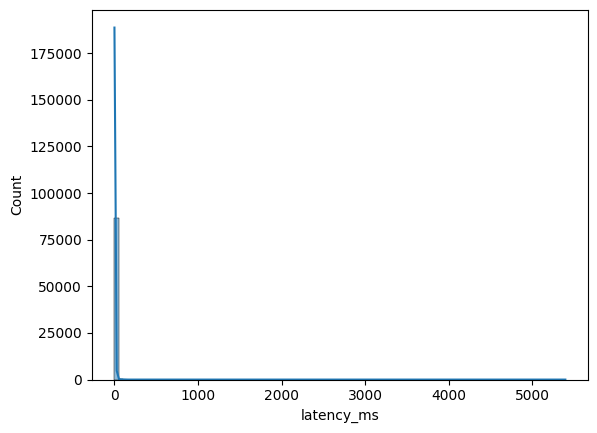

In [285]:
# plot the histogram of the latency
sns.histplot(submit_receive_df['latency_ms'], bins=100, kde=True)

In [286]:
# plot the average latency per minute
submit_receive_ot_df = pd.DataFrame()
submit_receive_ot_df['start_timestamp'] = submit_receive_df['timestamp']['min']
submit_receive_ot_df['latency_ms'] = submit_receive_df['latency_ms']
submit_receive_ot_df['minute'] = submit_receive_ot_df['start_timestamp'].dt.floor('T')

# group by minute and calculate the average latency
submit_receive_ot_df = submit_receive_ot_df.groupby('minute').agg({'latency_ms': ['mean', 'count']})

submit_receive_ot_df

/tmp/nix-shell.Y1yRQU/ipykernel_82869/3755674983.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  submit_receive_ot_df['minute'] = submit_receive_ot_df['start_timestamp'].dt.floor('T')


latency_ms      
                                mean count
minute                                    
2024-07-28 17:55:00+00:00   0.068500     2
2024-07-28 17:56:00+00:00   0.092035  2089
2024-07-28 17:57:00+00:00   0.104684    38
2024-07-28 17:58:00+00:00   0.081545  1983
2024-07-28 17:59:00+00:00  27.452271  1103
...                              ...   ...
2024-07-28 20:15:00+00:00   0.678925  2095
2024-07-28 20:31:00+00:00   0.070710    31
2024-07-28 20:32:00+00:00   0.095960  2372
2024-07-28 20:33:00+00:00   0.108117  1596
2024-07-28 20:38:00+00:00   0.077207   174

[66 rows x 2 columns]

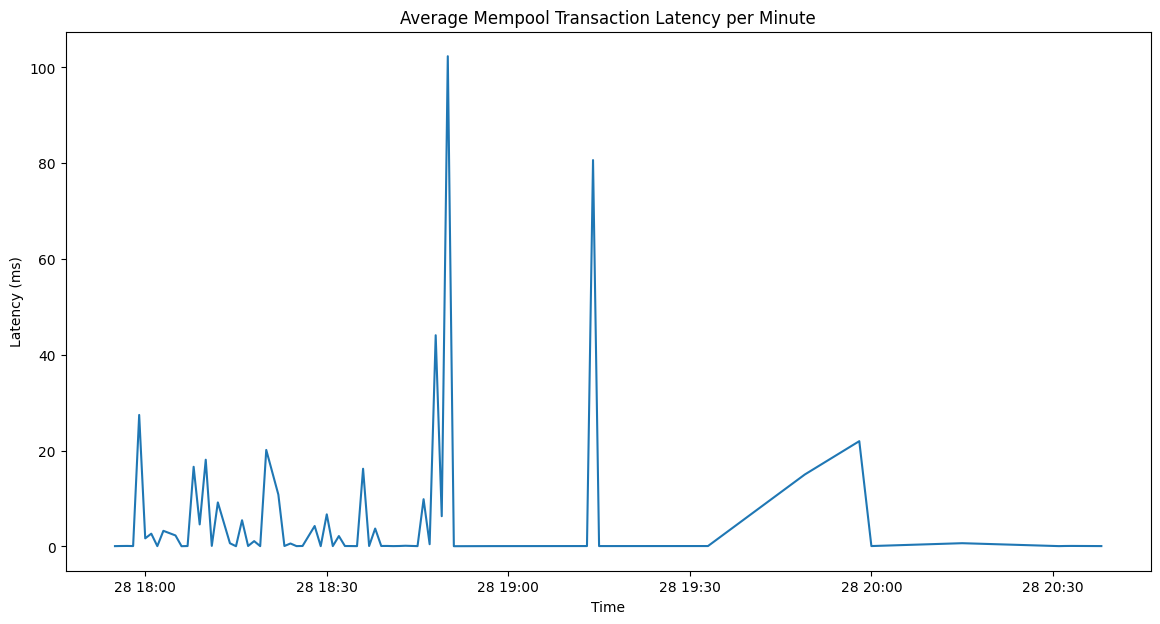

In [287]:
# plot the average latency per minute
plt.figure(figsize=(14, 7))
plt.plot(submit_receive_ot_df.index, submit_receive_ot_df['latency_ms']['mean'])
plt.xlabel('Time')
plt.ylabel('Latency (ms)')
plt.title('Average Mempool Transaction Latency per Minute')
plt.show()

### Executed

In [288]:
# block execution dataframe contains only records where 'message' is 'execute_block'
block_execution_df = suzuka_df[suzuka_df['message'] == 'execute_block']

# expand the 'spans' field
block_execution_df["block_id"] = block_execution_df["id"]

block_execution_df

/tmp/nix-shell.Y1yRQU/ipykernel_82869/1688822049.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  block_execution_df["block_id"] = block_execution_df["id"]


,timestamp,level,target,span,spans,message,time.busy,time.idle,batch_id,tx_hash,sender,sequence_number,block_id,fields,name,length,id
6,2024-07-28 17:55:02.418282+00:00,INFO,movement_timing,NaN,"[{'id': '""fkSB2Yk8ctJIoTtkGzcMjowcMc8uTRY+EK3s...",execute_block,NaN,NaN,NaN,NaN,NaN,NaN,"""fkSB2Yk8ctJIoTtkGzcMjowcMc8uTRY+EK3sK6DDKQs=""","{'message': 'transaction_in_block', 'tx_hash':...",execute_block,NaN,"""fkSB2Yk8ctJIoTtkGzcMjowcMc8uTRY+EK3sK6DDKQs="""
7,2024-07-28 17:55:02.418330+00:00,INFO,movement_timing,NaN,"[{'id': '""fkSB2Yk8ctJIoTtkGzcMjowcMc8uTRY+EK3s...",execute_block,NaN,NaN,NaN,NaN,NaN,NaN,"""fkSB2Yk8ctJIoTtkGzcMjowcMc8uTRY+EK3sK6DDKQs=""","{'message': 'transaction_in_block', 'tx_hash':...",execute_block,NaN,"""fkSB2Yk8ctJIoTtkGzcMjowcMc8uTRY+EK3sK6DDKQs="""
8,2024-07-28 17:55:02.418357+00:00,INFO,movement_timing,NaN,"[{'id': '""fkSB2Yk8ctJIoTtkGzcMjowcMc8uTRY+EK3s...",execute_block,NaN,NaN,NaN,NaN,NaN,NaN,"""fkSB2Yk8ctJIoTtkGzcMjowcMc8uTRY+EK3sK6DDKQs=""","{'message': 'transaction_in_block', 'tx_hash':...",execute_block,NaN,"""fkSB2Yk8ctJIoTtkGzcMjowcMc8uTRY+EK3sK6DDKQs="""
9,2024-07-28 17:55:02.418387+00:00,INFO,movement_timing,NaN,"[{'id': '""fkSB2Yk8ctJIoTtkGzcMjowcMc8uTRY+EK3s...",execute_block,NaN,NaN,NaN,NaN,NaN,NaN,"""fkSB2Yk8ctJIoTtkGzcMjowcMc8uTRY+EK3sK6DDKQs=""","{'message': 'transaction_in_block', 'tx_hash':...",execute_block,NaN,"""fkSB2Yk8ctJIoTtkGzcMjowcMc8uTRY+EK3sK6DDKQs="""
10,2024-07-28 17:55:02.418415+00:00,INFO,movement_timing,NaN,"[{'id': '""fkSB2Yk8ctJIoTtkGzcMjowcMc8uTRY+EK3s...",execute_block,NaN,NaN,NaN,NaN,NaN,NaN,"""fkSB2Yk8ctJIoTtkGzcMjowcMc8uTRY+EK3sK6DDKQs=""","{'message': 'transaction_in_block', 'tx_hash':...",execute_block,NaN,"""fkSB2Yk8ctJIoTtkGzcMjowcMc8uTRY+EK3sK6DDKQs="""
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269628,2024-07-28 20:38:17.047641+00:00,INFO,movement_timing,NaN,"[{'id': '""4/Xj2wvtHzjV5jId0U3uzF5veRE6+e9CFq89...",execute_block,NaN,NaN,NaN,NaN,NaN,NaN,"""4/Xj2wvtHzjV5jId0U3uzF5veRE6+e9CFq89okPElrk=""","{'message': 'transaction_in_block', 'tx_hash':...",execute_block,NaN,"""4/Xj2wvtHzjV5jId0U3uzF5veRE6+e9CFq89okPElrk="""
269629,2024-07-28 20:38:17.047666+00:00,INFO,movement_timing,NaN,"[{'id': '""4/Xj2wvtHzjV5jId0U3uzF5veRE6+e9CFq89...",execute_block,NaN,NaN,NaN,NaN,NaN,NaN,"""4/Xj2wvtHzjV5jId0U3uzF5veRE6+e9CFq89okPElrk=""","{'message': 'transaction_in_block', 'tx_hash':...",execute_block,NaN,"""4/Xj2wvtHzjV5jId0U3uzF5veRE6+e9CFq89okPElrk="""
269630,2024-07-28 20:38:17.047692+00:00,INFO,movement_timing,NaN,"[{'id': '""4/Xj2wvtHzjV5jId0U3uzF5veRE6+e9CFq89...",execute_block,NaN,NaN,NaN,NaN,NaN,NaN,"""4/Xj2wvtHzjV5jId0U3uzF5veRE6+e9CFq89okPElrk=""","{'message': 'transaction_in_block', 'tx_hash':...",execute_block,NaN,"""4/Xj2wvtHzjV5jId0U3uzF5veRE6+e9CFq89okPElrk="""
269631,2024-07-28 20:38:17.047718+00:00,INFO,movement_timing,NaN,"[{'id': '""4/Xj2wvtHzjV5jId0U3uzF5veRE6+e9CFq89...",execute_block,NaN,NaN,NaN,NaN,NaN,NaN,"""4/Xj2wvtHzjV5jId0U3uzF5veRE6+e9CFq89okPElrk=""","{'message': 'transaction_in_block', 'tx_hash':...",execute_block,NaN,"""4/Xj2wvtHzjV5jId0U3uzF5veRE6+e9CFq89okPElrk="""


In [289]:
block_execution_df['time.busy'].describe()

count       0
unique      0
top       NaN
freq      NaN
Name: time.busy, dtype: object

In [290]:
# form transaction_in_block_df
transaction_in_block_df = suzuka_df[suzuka_df['message'] == 'transaction_in_block']

# join on block_id with block_execution_df to get the time the block was executed
# preserve the timestamp from block_execution_df drop the timestamp from transaction_in_block_df
transaction_executed_df = transaction_in_block_df.merge(block_execution_df[['block_id', 'timestamp']], on='block_id')

transaction_executed_df["timestamp"] = transaction_executed_df["timestamp_y"]

# sort by timestamp
transaction_executed_df = transaction_executed_df.sort_values(by='timestamp')

# keep only the last timestamp for each tx_hash
transaction_executed_df = transaction_executed_df.groupby('tx_hash').agg({'timestamp': 'last', 'timestamp_x': 'first'})

transaction_executed_df


,timestamp,timestamp_x
tx_hash,,
000049dd,2024-07-28 18:34:29.372066+00:00,2024-07-28 18:34:29.261680+00:00
00013a01,2024-07-28 17:56:40.230152+00:00,2024-07-28 17:56:40.131407+00:00
00021eab,2024-07-28 18:26:51.435138+00:00,2024-07-28 18:26:51.333335+00:00
0002d582,2024-07-28 18:44:30.454830+00:00,2024-07-28 18:44:30.397128+00:00
0003bcb2,2024-07-28 18:07:20.438127+00:00,2024-07-28 18:07:20.306516+00:00
...,...,...
ffff0706,2024-07-28 17:56:38.125372+00:00,2024-07-28 17:56:38.014199+00:00
ffff7710,2024-07-28 18:07:24.573685+00:00,2024-07-28 18:07:24.457276+00:00
ffffa5fc,2024-07-28 18:42:23.589621+00:00,2024-07-28 18:42:23.484777+00:00


In [291]:
# calculate the processing time of execution, which is timestamp - timestamp_x
transaction_executed_df['processing_time'] = transaction_executed_df['timestamp'] - transaction_executed_df['timestamp_x']

# convert the processing time to milliseconds
transaction_executed_df['processing_time_ms'] = transaction_executed_df['processing_time'].dt.total_seconds() * 1000

transaction_executed_df

,timestamp,timestamp_x,processing_time,processing_time_ms
tx_hash,,,,
000049dd,2024-07-28 18:34:29.372066+00:00,2024-07-28 18:34:29.261680+00:00,0 days 00:00:00.110386,110.386
00013a01,2024-07-28 17:56:40.230152+00:00,2024-07-28 17:56:40.131407+00:00,0 days 00:00:00.098745,98.745
00021eab,2024-07-28 18:26:51.435138+00:00,2024-07-28 18:26:51.333335+00:00,0 days 00:00:00.101803,101.803
0002d582,2024-07-28 18:44:30.454830+00:00,2024-07-28 18:44:30.397128+00:00,0 days 00:00:00.057702,57.702
0003bcb2,2024-07-28 18:07:20.438127+00:00,2024-07-28 18:07:20.306516+00:00,0 days 00:00:00.131611,131.611
...,...,...,...,...
ffff0706,2024-07-28 17:56:38.125372+00:00,2024-07-28 17:56:38.014199+00:00,0 days 00:00:00.111173,111.173
ffff7710,2024-07-28 18:07:24.573685+00:00,2024-07-28 18:07:24.457276+00:00,0 days 00:00:00.116409,116.409
ffffa5fc,2024-07-28 18:42:23.589621+00:00,2024-07-28 18:42:23.484777+00:00,0 days 00:00:00.104844,104.844


In [292]:
# describe the processing time
transaction_executed_df['processing_time_ms'].describe()

count    85357.000000
mean       135.456757
std        365.173458
min         24.082000
25%         54.608000
50%        103.316000
75%        128.264000
max       5174.083000
Name: processing_time_ms, dtype: float64

/Users/l-monninger/dev/movement/research/movement-transaction-dataflow-v0_0_1/venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='processing_time_ms', ylabel='Count'>

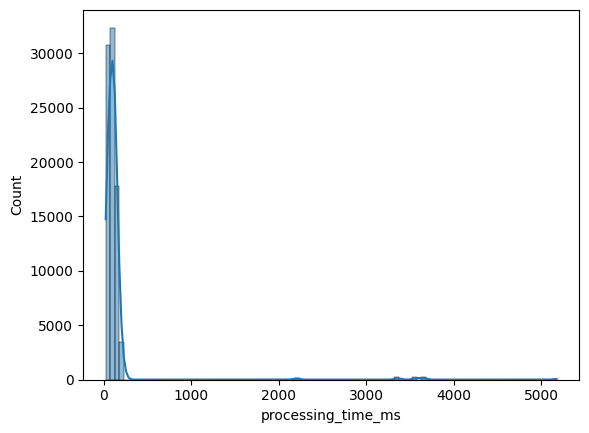

In [293]:
# plot a histogram of the processing time
sns.histplot(transaction_executed_df['processing_time_ms'], bins=100, kde=True)

In [294]:
# plot the average processing time per minute
transaction_executed_ot_df = pd.DataFrame()
transaction_executed_ot_df['start_timestamp'] = transaction_executed_df['timestamp_x']
transaction_executed_ot_df['processing_time_ms'] = transaction_executed_df['processing_time_ms']
transaction_executed_ot_df['minute'] = transaction_executed_ot_df['start_timestamp'].dt.floor('T')

# group by minute and calculate the average processing time
transaction_executed_ot_df = transaction_executed_ot_df.groupby('minute').agg({'processing_time_ms': ['mean', 'count']})

transaction_executed_ot_df

/tmp/nix-shell.Y1yRQU/ipykernel_82869/696091623.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  transaction_executed_ot_df['minute'] = transaction_executed_ot_df['start_timestamp'].dt.floor('T')


processing_time_ms      
                                        mean count
minute                                            
2024-07-28 17:55:00+00:00          25.682133    15
2024-07-28 17:56:00+00:00          99.355916  2089
2024-07-28 17:57:00+00:00          43.798143    21
2024-07-28 17:58:00+00:00         108.358706  2000
2024-07-28 17:59:00+00:00         150.249438   658
...                                      ...   ...
2024-07-28 20:16:00+00:00          44.429403   176
2024-07-28 20:31:00+00:00          34.916750     4
2024-07-28 20:32:00+00:00         320.854438  2146
2024-07-28 20:33:00+00:00         133.289476  1849
2024-07-28 20:38:00+00:00          75.599678   174

[68 rows x 2 columns]

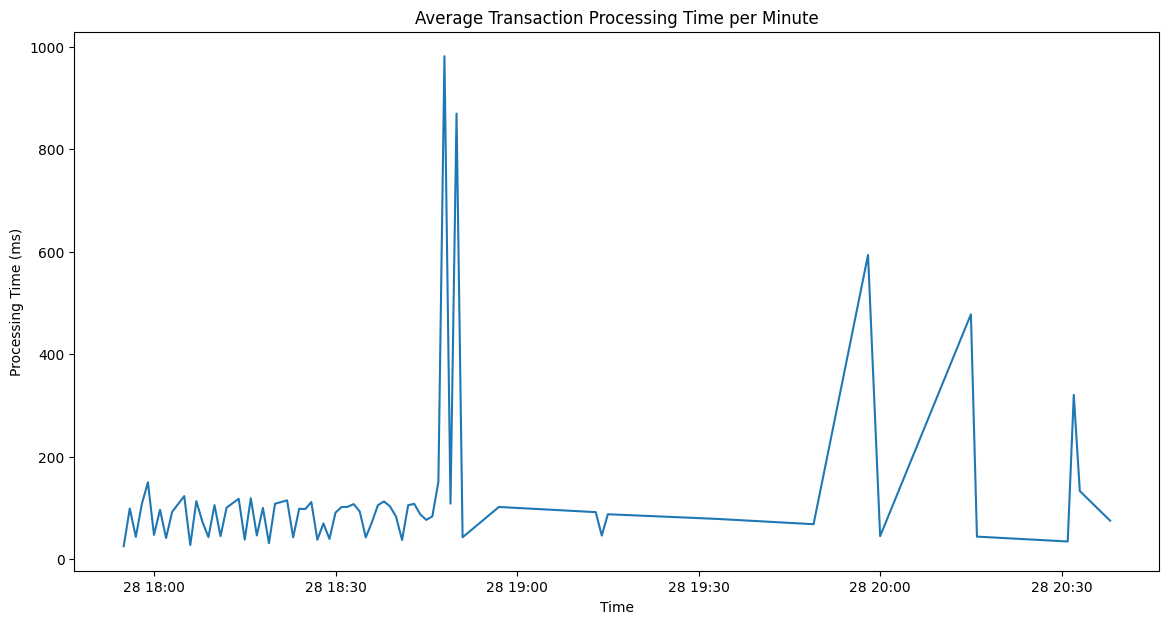

In [295]:
### plot the average processing time per minute
plt.figure(figsize=(14, 7))
plt.plot(transaction_executed_ot_df.index, transaction_executed_ot_df['processing_time_ms']['mean'])
plt.xlabel('Time')
plt.ylabel('Processing Time (ms)')
plt.title('Average Transaction Processing Time per Minute')
plt.show()

### Submit to Executed

In [296]:
# compute submit_df
submit_df = suzuka_df[suzuka_df['message'] == 'submit_transaction']

# join the submit_df with the transaction_executed_df on tx_hash
# use suffix to differentiate the timestamp columns
submit_executed_df = submit_df.merge(transaction_executed_df, on='tx_hash', suffixes=('_submit', '_executed'))

submit_executed_df

,timestamp_submit,level,target,span,spans,message,time.busy,time.idle,batch_id,tx_hash,...,sequence_number,block_id,fields,name,length,id,timestamp_executed,timestamp_x,processing_time,processing_time_ms
0,2024-07-28 17:55:01.778955+00:00,INFO,movement_timing,NaN,[],submit_transaction,NaN,NaN,NaN,c2fc7efd,...,40.0,NaN,"{'message': 'close', 'time.busy': '87.3µs', 't...",submit_transaction,NaN,NaN,2024-07-28 17:55:02.468886+00:00,2024-07-28 17:55:02.444762+00:00,0 days 00:00:00.024124,24.124
1,2024-07-28 17:55:01.900659+00:00,INFO,movement_timing,NaN,[],submit_transaction,NaN,NaN,NaN,e42542c1,...,41.0,NaN,"{'message': 'close', 'time.busy': '21.7µs', 't...",submit_transaction,NaN,NaN,2024-07-28 17:55:02.468886+00:00,2024-07-28 17:55:02.444804+00:00,0 days 00:00:00.024082,24.082
2,2024-07-28 17:56:13.074991+00:00,INFO,movement_timing,NaN,[],submit_transaction,NaN,NaN,NaN,19972519,...,2960.0,NaN,"{'message': 'close', 'time.busy': '35.6µs', 't...",submit_transaction,NaN,NaN,2024-07-28 17:56:14.963968+00:00,2024-07-28 17:56:14.932610+00:00,0 days 00:00:00.031358,31.358
3,2024-07-28 17:56:13.076613+00:00,INFO,movement_timing,NaN,[],submit_transaction,NaN,NaN,NaN,b96e43e2,...,2961.0,NaN,"{'message': 'close', 'time.busy': '64.9µs', 't...",submit_transaction,NaN,NaN,2024-07-28 17:56:14.963968+00:00,2024-07-28 17:56:14.932650+00:00,0 days 00:00:00.031318,31.318
4,2024-07-28 17:56:13.076807+00:00,INFO,movement_timing,NaN,[],submit_transaction,NaN,NaN,NaN,262e2d84,...,2962.0,NaN,"{'message': 'close', 'time.busy': '34.5µs', 't...",submit_transaction,NaN,NaN,2024-07-28 17:56:14.963968+00:00,2024-07-28 17:56:14.932681+00:00,0 days 00:00:00.031287,31.287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85339,2024-07-28 20:38:13.577309+00:00,INFO,movement_timing,NaN,[],submit_transaction,NaN,NaN,NaN,2fe40e96,...,8.0,NaN,"{'message': 'close', 'time.busy': '24.1µs', 't...",submit_transaction,NaN,NaN,2024-07-28 20:38:17.100855+00:00,2024-07-28 20:38:17.047589+00:00,0 days 00:00:00.053266,53.266
85340,2024-07-28 20:38:13.580084+00:00,INFO,movement_timing,NaN,[],submit_transaction,NaN,NaN,NaN,d70a8400,...,1.0,NaN,"{'message': 'close', 'time.busy': '22.2µs', 't...",submit_transaction,NaN,NaN,2024-07-28 20:38:17.100855+00:00,2024-07-28 20:38:17.046818+00:00,0 days 00:00:00.054037,54.037
85341,2024-07-28 20:38:13.581967+00:00,INFO,movement_timing,NaN,[],submit_transaction,NaN,NaN,NaN,c0ab33c4,...,8.0,NaN,"{'message': 'close', 'time.busy': '26.5µs', 't...",submit_transaction,NaN,NaN,2024-07-28 20:38:17.100855+00:00,2024-07-28 20:38:17.047563+00:00,0 days 00:00:00.053292,53.292
85342,2024-07-28 20:38:13.616380+00:00,INFO,movement_timing,NaN,[],submit_transaction,NaN,NaN,NaN,18dd9430,...,8.0,NaN,"{'message': 'close', 'time.busy': '23.3µs', 't...",submit_transaction,NaN,NaN,2024-07-28 20:38:17.100855+00:00,2024-07-28 20:38:17.047641+00:00,0 days 00:00:00.053214,53.214


In [298]:
# latency is timestamp_executed - timestamp_submit
submit_executed_df['latency'] = submit_executed_df['timestamp_executed'] - submit_executed_df['timestamp_submit']

# convert the latency to milliseconds
submit_executed_df['latency_ms'] = submit_executed_df['latency'].dt.total_seconds() * 1000

submit_executed_df

,timestamp_submit,level,target,span,spans,message,time.busy,time.idle,batch_id,tx_hash,...,fields,name,length,id,timestamp_executed,timestamp_x,processing_time,processing_time_ms,latency,latency_ms
0,2024-07-28 17:55:01.778955+00:00,INFO,movement_timing,NaN,[],submit_transaction,NaN,NaN,NaN,c2fc7efd,...,"{'message': 'close', 'time.busy': '87.3µs', 't...",submit_transaction,NaN,NaN,2024-07-28 17:55:02.468886+00:00,2024-07-28 17:55:02.444762+00:00,0 days 00:00:00.024124,24.124,0 days 00:00:00.689931,689.931
1,2024-07-28 17:55:01.900659+00:00,INFO,movement_timing,NaN,[],submit_transaction,NaN,NaN,NaN,e42542c1,...,"{'message': 'close', 'time.busy': '21.7µs', 't...",submit_transaction,NaN,NaN,2024-07-28 17:55:02.468886+00:00,2024-07-28 17:55:02.444804+00:00,0 days 00:00:00.024082,24.082,0 days 00:00:00.568227,568.227
2,2024-07-28 17:56:13.074991+00:00,INFO,movement_timing,NaN,[],submit_transaction,NaN,NaN,NaN,19972519,...,"{'message': 'close', 'time.busy': '35.6µs', 't...",submit_transaction,NaN,NaN,2024-07-28 17:56:14.963968+00:00,2024-07-28 17:56:14.932610+00:00,0 days 00:00:00.031358,31.358,0 days 00:00:01.888977,1888.977
3,2024-07-28 17:56:13.076613+00:00,INFO,movement_timing,NaN,[],submit_transaction,NaN,NaN,NaN,b96e43e2,...,"{'message': 'close', 'time.busy': '64.9µs', 't...",submit_transaction,NaN,NaN,2024-07-28 17:56:14.963968+00:00,2024-07-28 17:56:14.932650+00:00,0 days 00:00:00.031318,31.318,0 days 00:00:01.887355,1887.355
4,2024-07-28 17:56:13.076807+00:00,INFO,movement_timing,NaN,[],submit_transaction,NaN,NaN,NaN,262e2d84,...,"{'message': 'close', 'time.busy': '34.5µs', 't...",submit_transaction,NaN,NaN,2024-07-28 17:56:14.963968+00:00,2024-07-28 17:56:14.932681+00:00,0 days 00:00:00.031287,31.287,0 days 00:00:01.887161,1887.161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85339,2024-07-28 20:38:13.577309+00:00,INFO,movement_timing,NaN,[],submit_transaction,NaN,NaN,NaN,2fe40e96,...,"{'message': 'close', 'time.busy': '24.1µs', 't...",submit_transaction,NaN,NaN,2024-07-28 20:38:17.100855+00:00,2024-07-28 20:38:17.047589+00:00,0 days 00:00:00.053266,53.266,0 days 00:00:03.523546,3523.546
85340,2024-07-28 20:38:13.580084+00:00,INFO,movement_timing,NaN,[],submit_transaction,NaN,NaN,NaN,d70a8400,...,"{'message': 'close', 'time.busy': '22.2µs', 't...",submit_transaction,NaN,NaN,2024-07-28 20:38:17.100855+00:00,2024-07-28 20:38:17.046818+00:00,0 days 00:00:00.054037,54.037,0 days 00:00:03.520771,3520.771
85341,2024-07-28 20:38:13.581967+00:00,INFO,movement_timing,NaN,[],submit_transaction,NaN,NaN,NaN,c0ab33c4,...,"{'message': 'close', 'time.busy': '26.5µs', 't...",submit_transaction,NaN,NaN,2024-07-28 20:38:17.100855+00:00,2024-07-28 20:38:17.047563+00:00,0 days 00:00:00.053292,53.292,0 days 00:00:03.518888,3518.888
85342,2024-07-28 20:38:13.616380+00:00,INFO,movement_timing,NaN,[],submit_transaction,NaN,NaN,NaN,18dd9430,...,"{'message': 'close', 'time.busy': '23.3µs', 't...",submit_transaction,NaN,NaN,2024-07-28 20:38:17.100855+00:00,2024-07-28 20:38:17.047641+00:00,0 days 00:00:00.053214,53.214,0 days 00:00:03.484475,3484.475


In [299]:
### describe the latency
submit_executed_df['latency_ms'].describe()

count    85344.000000
mean      4407.314559
std       2868.039485
min        325.011000
25%       2951.590250
50%       3552.228500
75%       4118.135250
max      17674.680000
Name: latency_ms, dtype: float64

/Users/l-monninger/dev/movement/research/movement-transaction-dataflow-v0_0_1/venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='latency_ms', ylabel='Count'>

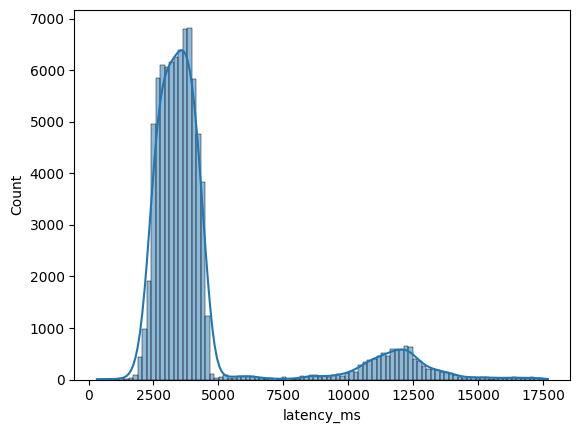

In [300]:
### plot the histogram of the latency
sns.histplot(submit_executed_df['latency_ms'], bins=100, kde=True)

In [301]:
### plot the average latency per minute
submit_executed_ot_df = pd.DataFrame()
submit_executed_ot_df['start_timestamp'] = submit_executed_df['timestamp_submit']
submit_executed_ot_df['latency_ms'] = submit_executed_df['latency_ms']
submit_executed_ot_df['minute'] = submit_executed_ot_df['start_timestamp'].dt.floor('T')

### group by minute and calculate the average latency
submit_executed_ot_df = submit_executed_ot_df.groupby('minute').agg({'latency_ms': ['mean', 'count']})

submit_executed_ot_df

/tmp/nix-shell.Y1yRQU/ipykernel_82869/381009869.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  submit_executed_ot_df['minute'] = submit_executed_ot_df['start_timestamp'].dt.floor('T')


latency_ms      
                                  mean count
minute                                      
2024-07-28 17:55:00+00:00   629.079000     2
2024-07-28 17:56:00+00:00  3625.130674  2089
2024-07-28 17:57:00+00:00  2952.017184    38
2024-07-28 17:58:00+00:00  3385.709408  1983
2024-07-28 17:59:00+00:00  6494.023287  1103
...                                ...   ...
2024-07-28 20:15:00+00:00  5585.440322  2095
2024-07-28 20:31:00+00:00  2977.337387    31
2024-07-28 20:32:00+00:00  3854.512979  2372
2024-07-28 20:33:00+00:00  3429.707836  1596
2024-07-28 20:38:00+00:00  3211.248563   174

[66 rows x 2 columns]

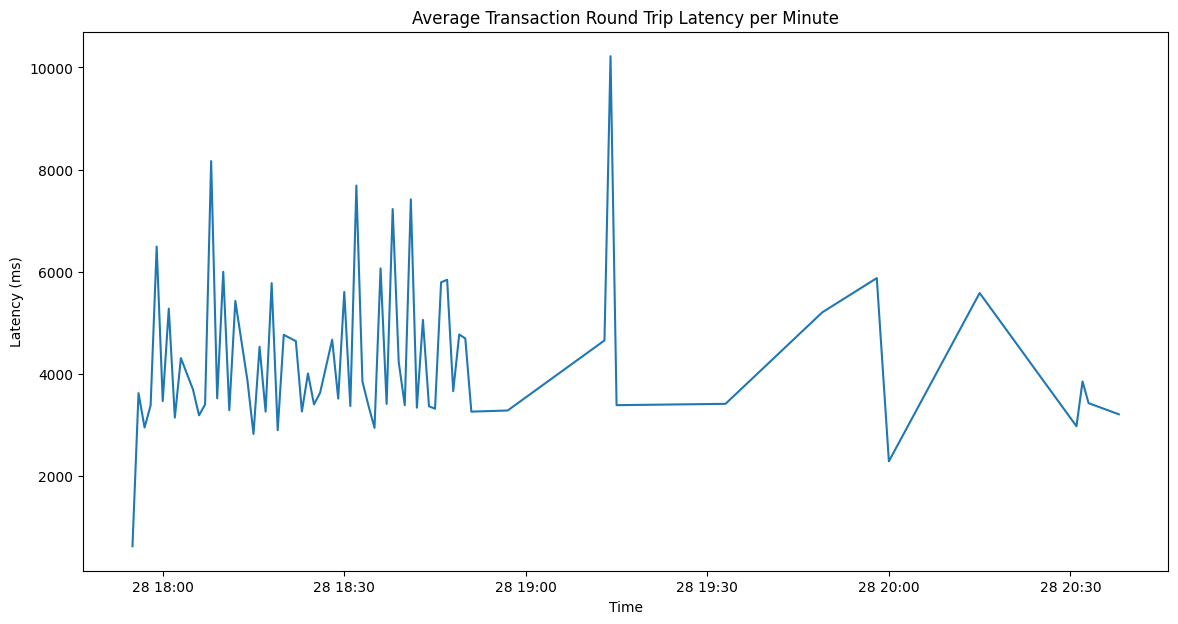

In [302]:
### plot the average latency per minute
plt.figure(figsize=(14, 7))
plt.plot(submit_executed_ot_df.index, submit_executed_ot_df['latency_ms']['mean'])
plt.xlabel('Time')
plt.ylabel('Latency (ms)')
plt.title('Average Transaction Round Trip Latency per Minute')
plt.show()